In [20]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from datetime import date
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [21]:
today = date.today()
yesterday = today - timedelta(days = 1)

In [22]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=yesterday)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.519279
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.586558
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.726294
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.859335
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.838937
...,...,...,...,...,...,...
2022-11-15,153.589996,148.559998,152.220001,150.039993,89868300.0,150.039993
2022-11-16,149.869995,147.289993,149.130005,148.789993,64218300.0,148.789993
2022-11-17,151.479996,146.149994,146.429993,150.720001,80389400.0,150.720001


In [23]:
df.shape

(2741, 6)

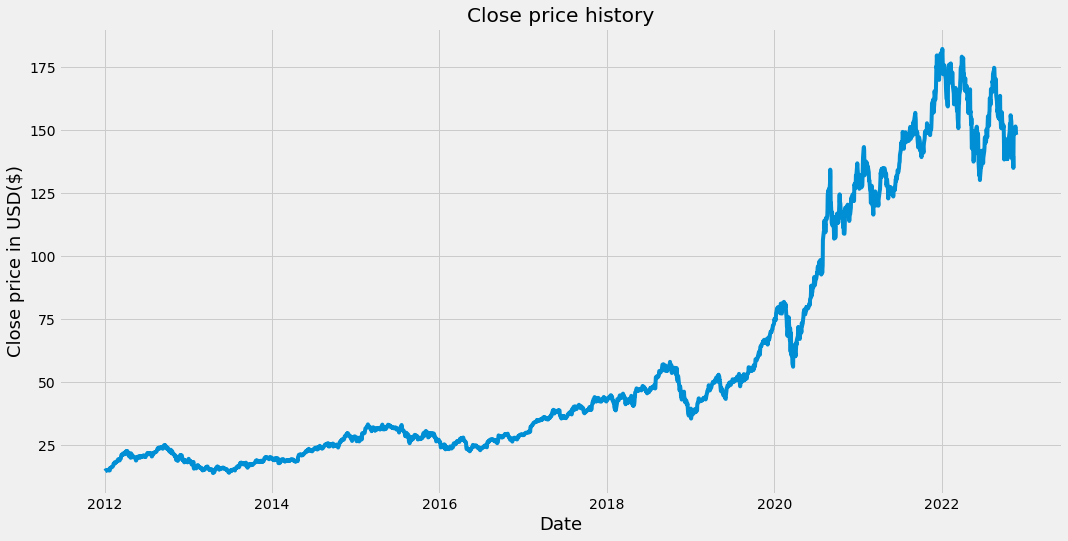

In [24]:
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price in USD($)', fontsize=18)
plt.show()

In [25]:
data = df.filter(['Close'])

dataset = data.values # convert to numpy array

training_data_length = math.ceil(len(dataset) * 0.8)

In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [27]:
# create training data set
train_data = scaled_data[:training_data_length, :]
x_train = [] #independent training variabls
y_train = [] #dependent training variables

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

#x_train contains 60 values which are used to train the 61th value
#   which is stored in y_train variable

In [28]:
#convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [29]:
#Reshape the data as LSTM expects input to be 3D but our current dataset is 2D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [30]:
# Now we will build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [31]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2133/2133 [==============================] - 66s 28ms/step - loss: 6.0981e-04


In [33]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_length - 60:, :]

x_test = []
y_test = dataset[training_data_length: , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i - 60: i, 0])

In [34]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [35]:
# Reshape again to make it 3D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #unscaling values

18/18 [==============================] - 1s 18ms/step


In [37]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

6.52997513931163

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


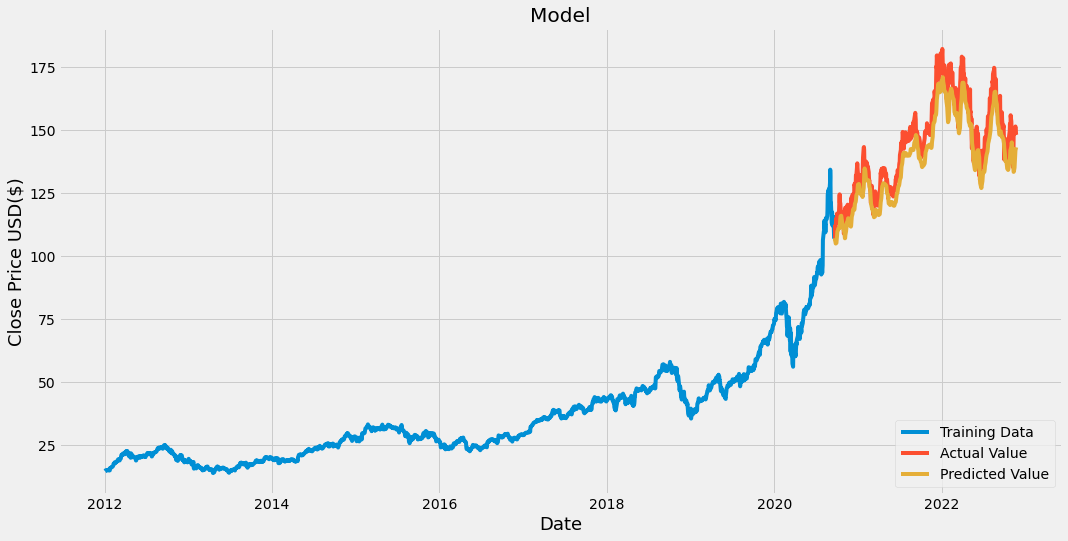

In [39]:
# Plot the data
train = data[:training_data_length]
actual_val = data[training_data_length:]
actual_val['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(actual_val[['Close', 'Predictions']])
plt.legend(['Training Data', 'Actual Value', 'Predicted Value'], loc = 'lower right')

In [41]:
# Show the valid and predicted prices
actual_val

,Close,Predictions
Date,,
2020-09-21,110.080002,106.951736
2020-09-22,111.809998,106.130676
2020-09-23,107.120003,105.916046
2020-09-24,108.220001,105.361206
2020-09-25,112.279999,104.904274
...,...,...
2022-11-15,150.039993,136.768250
2022-11-16,148.789993,138.768234
2022-11-17,150.720001,140.360550


In [44]:
# Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=yesterday)
new_df = apple_quote.filter(['Close'])

last_60_days = new_df[-60:].values #convert to np array
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_scale_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_scale_price)

print(pred_price)

1/1 [==============================] - 0s 24ms/step
[[143.44511]]


In [46]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start=today, end=today)
print(apple_quote2['Close'])

Date
2022-11-22    149.199997
Name: Close, dtype: float64
